In [ ]:
#importing requiredd libraries

import torch
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision
from torch import nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#loading training and validation data of CIFAR10 Dataset

train_data = datasets.CIFAR10(root = './data' , train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.CIFAR10(root = './data', train = False, download = True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data[1]

(tensor([[[0.6039, 0.4941, 0.4118,  ..., 0.3569, 0.3412, 0.3098],
          [0.5490, 0.5686, 0.4902,  ..., 0.3765, 0.3020, 0.2784],
          [0.5490, 0.5451, 0.4510,  ..., 0.3098, 0.2667, 0.2627],
          ...,
          [0.6863, 0.6118, 0.6039,  ..., 0.1647, 0.2392, 0.3647],
          [0.6471, 0.6118, 0.6235,  ..., 0.4039, 0.4824, 0.5137],
          [0.6392, 0.6196, 0.6392,  ..., 0.5608, 0.5608, 0.5608]],
 
         [[0.6941, 0.5373, 0.4078,  ..., 0.3725, 0.3529, 0.3176],
          [0.6275, 0.6000, 0.4902,  ..., 0.3882, 0.3137, 0.2863],
          [0.6078, 0.5725, 0.4510,  ..., 0.3216, 0.2745, 0.2706],
          ...,
          [0.6549, 0.6039, 0.6275,  ..., 0.1333, 0.2078, 0.3255],
          [0.6039, 0.5961, 0.6314,  ..., 0.3647, 0.4471, 0.4745],
          [0.5804, 0.5804, 0.6118,  ..., 0.5216, 0.5255, 0.5216]],
 
         [[0.7333, 0.5333, 0.3725,  ..., 0.2784, 0.2784, 0.2745],
          [0.6627, 0.6039, 0.4627,  ..., 0.3059, 0.2431, 0.2392],
          [0.6431, 0.5843, 0.4392,  ...,

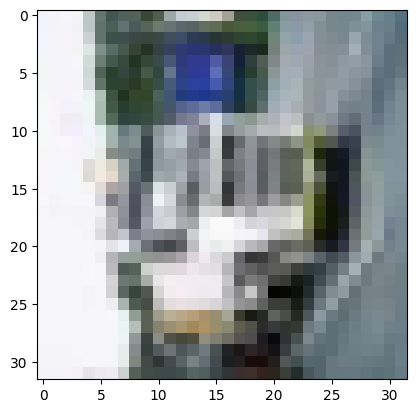

In [ ]:
plt.imshow(train_data[1000][0].numpy().T)

In [ ]:
#DataPreprocessing Task - Normalisation, tensor conversion

mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
normalize = transforms.Normalize(mean, std)
train_data.transform = transforms.Compose([transforms.ToTensor(),normalize])
test_data.transform = transforms.Compose([transforms.ToTensor(),normalize])

In [ ]:
train_data[0][0]

tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -0

In [ ]:
print(f'Size of train data : {len(train_data)}')
print(f'Size of test data : {len(test_data)}')

Size of train data : 50000
Size of test data : 10000


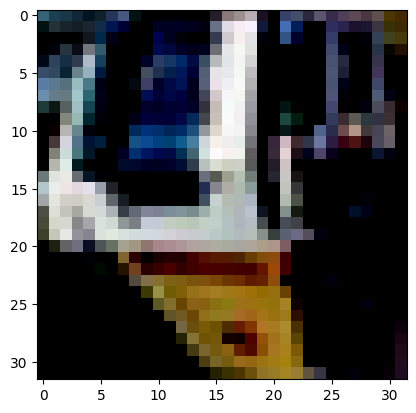

In [ ]:
plt.imshow(train_data[1][0].numpy().T)

# Vision Transformers

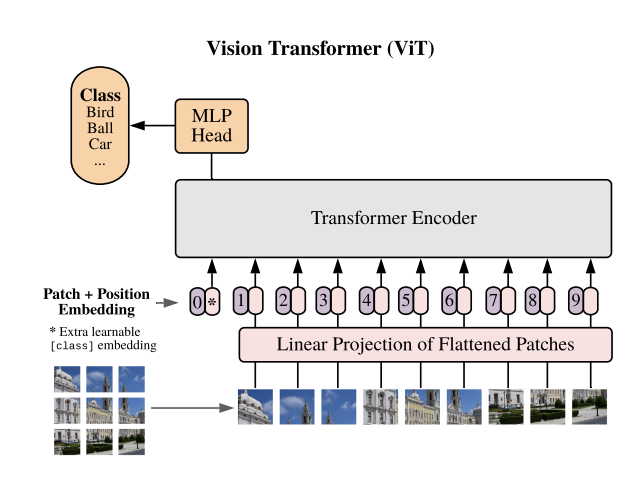

In [ ]:
#first layer - patchification of image

def patchify(images, n_patches=8, stride=8):
    batch_patches = []
    for image in images:
        patches = []
        c, h, w = image.size()
        for i in range(0, h - n_patches + 1, stride):
            for j in range(0, w - n_patches + 1, stride):
                patch = image[:, i:i+n_patches, j:j+n_patches]
                patches.append(patch.flatten())
        batch_patches.append(torch.stack(patches))  # Stack patches into a tensor and append to the list
    return batch_patches

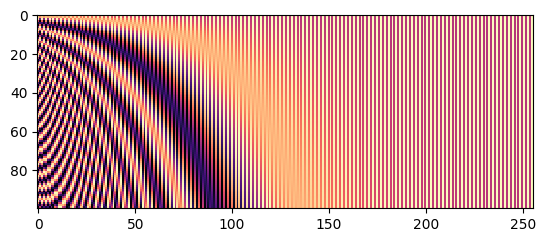

In [ ]:
#traditional sinsuidal positional encoding

def positional_encoding_trignometric_traditional(sequence_length, d = 256):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

plt.imshow(positional_encoding_trignometric_traditional(100), cmap="magma", interpolation="nearest")

In [ ]:
#second layer - linear projection of these patches to 256 embedding vectors
#third layer - positional encoding of these patch sequences(learnable positional encoding instead of standard sinsuidal one) + cls_token for downstream
             # -purpose like image classification etc.
#fourth and final mlp layers in transformer_encoder

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim), num_layers=depth)
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embedding(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.positional_embedding
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x



In [ ]:
!nvidia-smi

Tue Jan  2 17:06:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0              31W /  70W |    251MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Initialize model
vit_model = VisionTransformer(image_size=32, patch_size=8, num_classes=10, dim=64, depth=6, heads=8, mlp_dim=128)

#gpu acceleration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
vit_model.to(device)

VisionTransformer(
  (patch_embedding): Conv2d(3, 64, kernel_size=(8, 8), stride=(8, 8))
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
#training of this scratch model

def vit_training(model_param):
  batch_size = 1 #for mini-batch gradient descent
  model_param.to(device)

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model_param.parameters(), lr=0.001)
  num_epochs = 10
  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_param(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10000 == 9999:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / 200:.4f}')
            running_loss = 0.0
  print('Finished Training')
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_param(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images for regularisation : {accuracy:.2f}%')

vit_training(vit_model)

Epoch [1/10], Batch [10000/50000], Loss: 80.1920
Epoch [1/10], Batch [20000/50000], Loss: 80.5140
Epoch [1/10], Batch [30000/50000], Loss: 79.0111
Epoch [1/10], Batch [40000/50000], Loss: 79.5724
Epoch [1/10], Batch [50000/50000], Loss: 78.0552
Epoch [2/10], Batch [10000/50000], Loss: 77.6545
Epoch [2/10], Batch [20000/50000], Loss: 76.8919
Epoch [2/10], Batch [30000/50000], Loss: 77.4151
Epoch [2/10], Batch [40000/50000], Loss: 75.6533
Epoch [2/10], Batch [50000/50000], Loss: 75.1458
Epoch [3/10], Batch [10000/50000], Loss: 75.3988
Epoch [3/10], Batch [20000/50000], Loss: 74.5694
Epoch [3/10], Batch [30000/50000], Loss: 74.0132
Epoch [3/10], Batch [40000/50000], Loss: 74.9734
Epoch [3/10], Batch [50000/50000], Loss: 72.9327
Epoch [4/10], Batch [10000/50000], Loss: 73.4271
Epoch [4/10], Batch [20000/50000], Loss: 72.9979
Epoch [4/10], Batch [30000/50000], Loss: 72.4714
Epoch [4/10], Batch [40000/50000], Loss: 72.6311
Epoch [4/10], Batch [50000/50000], Loss: 72.0460
Epoch [5/10], Batch 

In [ ]:
#saving this trained model as checkpoint

torch.save(vit_model.state_dict(), 'saved_model.pth')

model = VisionTransformer(image_size=32, patch_size=8, num_classes=10, dim=64, depth=6, heads=8, mlp_dim=128)
model.load_state_dict(torch.load('saved_model.pth'))
model.eval()

VisionTransformer(
  (patch_embedding): Conv2d(3, 64, kernel_size=(8, 8), stride=(8, 8))
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
img = train_data[1000][0]
img.shape

torch.Size([3, 32, 32])

In [ ]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 32, 32])

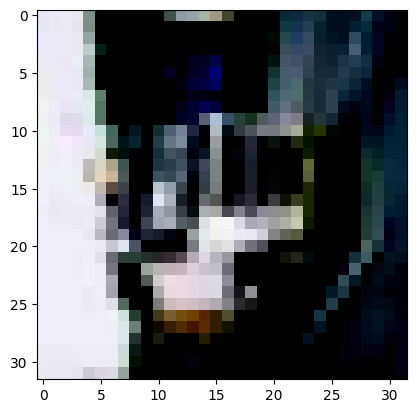

In [ ]:
plt.imshow(train_data[1000][0].numpy().T)

In [ ]:
# 1 =  Airplane
# 2 = Automobile
# 3 = Bird
# 4 = Cat
# 5 = Deer
# 6 = Dog
# 7 = Frog
# 8 = Horse
# 9 = Ship
# 10 = Truck

In [ ]:
#output of this model for given input image
model.to(device)
with torch.no_grad():
  output = model(img.to(device))

In [ ]:
output

tensor([[ 0.2034,  0.0060, -0.1863, -0.3225, -0.3914, -0.0931, -0.2078, -0.0160,
          0.1791, -0.1001]], device='cuda:0')

In [ ]:
#extracting weights
attn_weights = []


for layer in model.transformer.layers:
    attn_weights.append(layer.self_attn.in_proj_weight)


attn_weights

[Parameter containing:
 tensor([[-0.0845,  0.0238,  0.1377,  ...,  0.1236,  0.0821,  0.0628],
         [ 0.0928, -0.0772,  0.0510,  ..., -0.0178, -0.1067, -0.0783],
         [ 0.0775,  0.0976,  0.1036,  ...,  0.1251, -0.1056, -0.0940],
         ...,
         [-0.0508,  0.0722, -0.1473,  ...,  0.1075, -0.0728, -0.0523],
         [-0.0491,  0.0382, -0.1138,  ..., -0.1267,  0.0178, -0.1164],
         [-0.1360, -0.0453,  0.1294,  ..., -0.1529,  0.1496,  0.0621]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0845,  0.0238,  0.1377,  ...,  0.1236,  0.0820,  0.0628],
         [ 0.0928, -0.0773,  0.0511,  ..., -0.0178, -0.1065, -0.0782],
         [ 0.0775,  0.0976,  0.1036,  ...,  0.1251, -0.1056, -0.0939],
         ...,
         [-0.0510,  0.0724, -0.1473,  ...,  0.1076, -0.0730, -0.0526],
         [-0.0491,  0.0386, -0.1125,  ..., -0.1266,  0.0180, -0.1153],
         [-0.1364, -0.0446,  0.1298,  ..., -0.1529,  0.1500,  0.0621]],
        device='cuda:0', r

In [ ]:
attn_weights[0].shape

torch.Size([192, 64])

In [ ]:
# Accessing the transformer encoder from the model
transformer_encoder = model.transformer

q_weights = []
k_weights = []
v_weights = []
# Extracting parameters for each transformer layer
for layer_idx, layer in enumerate(transformer_encoder.layers):
    print(f"Transformer Layer {layer_idx + 1}:")

    # Accessing query, key, value weights for the self-attention mechanism
    query_weight = layer.self_attn.in_proj_weight[:layer.self_attn.embed_dim]
    q_weights.append(query_weight)
    key_weight = layer.self_attn.in_proj_weight[layer.self_attn.embed_dim : 2 * layer.self_attn.embed_dim]
    k_weights.append(key_weight)
    value_weight = layer.self_attn.in_proj_weight[2 * layer.self_attn.embed_dim :]
    v_weights.append(value_weight)

    print(f"Query weight shape: {query_weight.shape}")
    print(f"Key weight shape: {key_weight.shape}")
    print(f"Value weight shape: {value_weight.shape}")

Transformer Layer 1:
Query weight shape: torch.Size([64, 64])
Key weight shape: torch.Size([64, 64])
Value weight shape: torch.Size([64, 64])
Transformer Layer 2:
Query weight shape: torch.Size([64, 64])
Key weight shape: torch.Size([64, 64])
Value weight shape: torch.Size([64, 64])
Transformer Layer 3:
Query weight shape: torch.Size([64, 64])
Key weight shape: torch.Size([64, 64])
Value weight shape: torch.Size([64, 64])
Transformer Layer 4:
Query weight shape: torch.Size([64, 64])
Key weight shape: torch.Size([64, 64])
Value weight shape: torch.Size([64, 64])
Transformer Layer 5:
Query weight shape: torch.Size([64, 64])
Key weight shape: torch.Size([64, 64])
Value weight shape: torch.Size([64, 64])
Transformer Layer 6:
Query weight shape: torch.Size([64, 64])
Key weight shape: torch.Size([64, 64])
Value weight shape: torch.Size([64, 64])


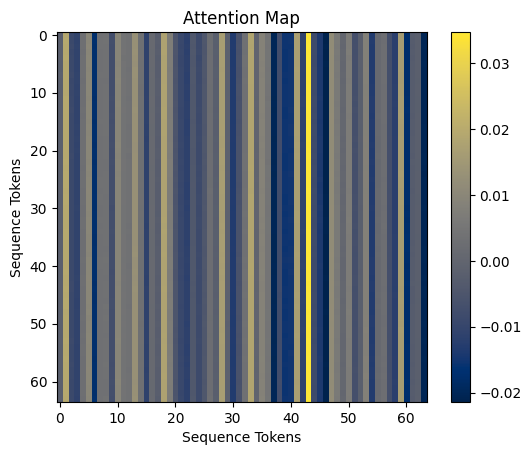

In [ ]:
attention_scores = torch.matmul(q_weights[2], k_weights[2].transpose(-1,-2))/8

# Appling softmax to get attention probabilities
attention_probs = (torch.nn.functional.softmax(attention_scores, dim=-1))@v_weights[2]

# Visualizing the attention map using libraries like Matplotlib
import matplotlib.pyplot as plt

attention_probs = attention_probs.detach().cpu().numpy()

plt.imshow(attention_probs, cmap='cividis', interpolation='nearest')
plt.title('Attention Map')
plt.xlabel('Sequence Tokens')
plt.ylabel('Sequence Tokens')
plt.colorbar()
plt.show()

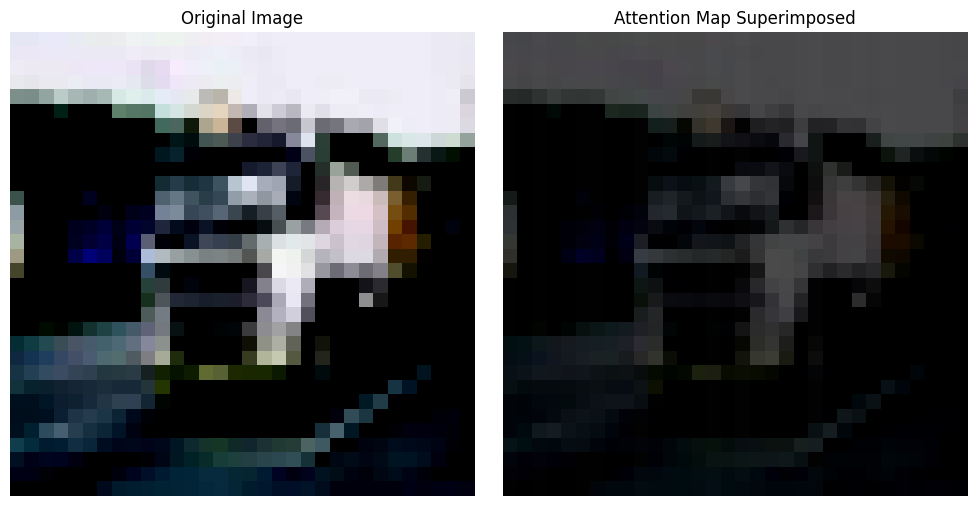

In [ ]:
import torchvision.transforms.functional as TF

# Resizing attention_probs to match the image dimensions
attention_probs_resized = torch.nn.functional.interpolate(
    torch.tensor(attention_probs).unsqueeze(0).unsqueeze(0),
    size=img.shape[-2:],
    mode='bilinear',
    align_corners=False,
).squeeze().numpy()

# Normalizing attention_probs_resized
attention_map = (attention_probs_resized - attention_probs_resized.min()) / (
    attention_probs_resized.max() - attention_probs_resized.min()
)

# Enhancing the attention map to make it more prominent
attention_map = (attention_map * 2) ** 2  # Increasing the intensity

# Converting the attention map to the same shape as the image
attention_map = TF.to_pil_image(attention_map)

# Converting the tensor image to a numpy array
img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()

# Displaying the original image and the attention map superimposed on it
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_np)
axes[1].imshow(attention_map, alpha=0.7, cmap='cividis', interpolation='nearest')
axes[1].set_title('Attention Map Superimposed')
axes[1].axis('off')

plt.tight_layout()
plt.show()
